In [2]:
import pandas as pd
import numpy as np

from pyincore import IncoreClient
from pyincore.analyses.socialvulnerability import SocialVulnerability
from pyincore_data.censusutil import CensusUtil
from pyincore import Dataset

In [3]:
client = IncoreClient()

Enter username:  zacbaker
Enter password:  ········


Connection successful to IN-CORE services. pyIncore version detected: 1.14.0


In [4]:
state = "florida"
county = "lee"
year = 2022

In [5]:
# get fips code to use fetch census data
fips = CensusUtil.get_fips_by_state_county(state=state, county=county)
state_code = fips[:2]
county_code = fips[2:]
fips

'12071'

In [6]:
def demographic_factors(state_number, county_number, year, geo_type="tract:*"):

    api_json_1, df_1, ds_1 = CensusUtil.get_census_data(state=state_code, county=county_code, year=year,
                                                              data_source="acs/acs5",
                                                              columns="GEO_ID,B03002_001E,B03002_003E",
                                                              geo_type=geo_type)
    df_1["factor_white_nonHispanic"] = df_1[["B03002_001E","B03002_003E"]].astype(int).apply(lambda row: row["B03002_003E"]/row["B03002_001E"] if row["B03002_001E"] != 0 else 999, axis = 1)

    api_json_2, df_2, ds_2 = CensusUtil.get_census_data(state=state_code, county=county_code, year=year,
                                                  data_source="acs/acs5",
                                                  columns="B25003_001E,B25003_002E",
                                                  geo_type=geo_type)
    df_2["factor_owner_occupied"] = df_2.astype(int).apply(lambda row: row["B25003_002E"]/row["B25003_001E"] if row["B25003_001E"] != 0 else 999, axis = 1)
    
    api_json_3, df_3, ds_3 = CensusUtil.get_census_data(state=state_code, 
                                         county=county_code, 
                                         year=year,
                                         data_source="acs/acs5",
                                         columns="B17021_001E,B17021_002E",
                                         geo_type=geo_type)
    df_3["factor_earning_higher_than_national_poverty_rate"] = df_3.astype(int).apply(lambda row: 1-row["B17021_002E"]/row["B17021_001E"] if row["B17021_001E"] != 0 else 999, axis = 1)
    
    api_json_4, df_4, ds_4 = CensusUtil.get_census_data(state=state_code, 
                                         county=county_code, 
                                         year=year,
                                         data_source="acs/acs5", 
                                         columns="B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15003_021E,B15003_022E,B15003_023E,B15003_024E,B15003_025E",
                                         geo_type=geo_type)
    df_4["factor_over_25_with_high_school_diploma_or_higher"] = df_4.astype(int).apply(lambda row: (row["B15003_017E"] 
                                                                                                    + row["B15003_018E"] 
                                                                                                    + row["B15003_019E"] 
                                                                                                    + row["B15003_020E"] 
                                                                                                    + row["B15003_021E"] 
                                                                                                    + row["B15003_022E"] 
                                                                                                    + row["B15003_023E"] 
                                                                                                    + row["B15003_024E"] 
                                                                                                    + row["B15003_025E"])/row["B15003_001E"] if row["B15003_001E"] != 0 else 999, axis = 1)

    if geo_type == 'tract:*':
        api_json_5, df_5, ds_5 = CensusUtil.get_census_data(state=state_code, 
                                             county=county_code, 
                                             year=year,
                                             data_source="acs/acs5",
                                             columns="B18101_001E,B18101_011E,B18101_014E,B18101_030E,B18101_033E",
                                             geo_type=geo_type)
        df_5["factor_without_disability_age_18_to_65"] = df_5.astype(int).apply(lambda row: (row["B18101_011E"] + row["B18101_014E"] + row["B18101_030E"] + row["B18101_033E"])/row["B18101_001E"] if row["B18101_001E"] != 0 else 999, axis = 1)
    
    elif geo_type == 'block%20group:*':
        api_json_5, df_5, ds_5 = CensusUtil.get_census_data(state=state_code, 
                                             county=county_code, 
                                             year=year,
                                             data_source="acs/acs5",
                                             columns="B01003_001E,C21007_006E,C21007_009E,C21007_013E,C21007_016E",
                                             geo_type=geo_type)

        df_5['factor_without_disability_age_18_to_65'] = df_5.astype(int).apply(lambda row: (row['C21007_006E']+
                                                                                 row['C21007_006E']+
                                                                                 row['C21007_009E']+
                                                                                 row['C21007_013E'])
                                                                                /row['C21007_016E'] if row["C21007_016E"] != 0 else 999, axis = 1)

    df_t = pd.concat([df_1[["GEO_ID","factor_white_nonHispanic"]],
                      df_2["factor_owner_occupied"],
                      df_3["factor_earning_higher_than_national_poverty_rate"], 
                      df_4["factor_over_25_with_high_school_diploma_or_higher"],
                      df_5["factor_without_disability_age_18_to_65"]], 
                     axis=1, join='inner')
    
    # extract FIPS from geo id
    df_t["FIPS"] = df_t.apply(lambda row: row["GEO_ID"].split("US")[1], axis = 1)
        
    return df_t

In [7]:
def national_ave_values (year, data_source="acs/acs5"):
    api_json_1, nav1, ds_1 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B03002_001E,B03002_003E",geo_type=None)
    nav1 = nav1.astype(int)
    nav1_avg ={"feature": "NAV-1: White, nonHispanic", 
                "average": nav1['B03002_003E'].sum()/ nav1['B03002_001E'].sum()}

    api_json_2, nav2, ds_2 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B25003_001E,B25003_002E",geo_type=None)
    nav2 = nav2.astype(int)
    nav2_avg = {"feature": "NAV-2: Home Owners", 
                "average": nav2['B25003_002E'].sum()/nav2['B25003_001E'].sum()}

    api_json_3, nav3, ds_3 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B17021_001E,B17021_002E",geo_type=None)
    nav3 = nav3.astype(int)
    nav3_avg = {"feature": "NAV-3: earning higher than national poverty rate", 
                "average": 1-nav3['B17021_002E'].sum()/nav3['B17021_001E'].sum()}

    api_json_4, nav4, ds_4 = CensusUtil.get_census_data(state="*", 
                                         county=None, 
                                         year=year,
                                         data_source="acs/acs5",
                                         columns="B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15003_021E,B15003_022E,B15003_023E,B15003_024E,B15003_025E",
                                         geo_type=None)
    nav4 = nav4.astype(int)
    nav4['temp'] = nav4.apply(lambda row: row['B15003_017E']+row['B15003_018E']+row['B15003_019E']+
                              row['B15003_020E']+row['B15003_021E']+row['B15003_022E']+row['B15003_023E']+
                              row['B15003_024E']+row['B15003_025E'], axis = 1)
    nav4_avg = {"feature": 'NAV-4: over 25 with high school diploma or higher', 
                "average": nav4['temp'].sum()/nav4['B15003_001E'].sum()}

    api_json_5, nav5, ds_5 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
                             columns="B18101_001E,B18101_011E,B18101_014E,B18101_030E,B18101_033E",
                                         geo_type=None)
    nav5 = nav5.astype(int)
    nav5['temp'] = nav5.apply(lambda row: row['B18101_011E']+row['B18101_014E']+row['B18101_030E']+row['B18101_033E'], axis = 1)
    nav5_avg = {"feature": 'NAV-5: without disability age 18 to 65', 
                "average": nav5["temp"].sum()/nav5["B18101_001E"].sum()}
    
    navs = [nav1_avg, nav2_avg, nav3_avg, nav4_avg, nav5_avg]
    
    return navs

In [8]:
navs = national_ave_values(year=2022)
national_vulnerability_feature_averages = Dataset.from_csv_data(navs, name="national_vulnerability_feature_averages.csv",
                                                                 data_type="incore:socialVulnerabilityFeatureAverages")

csv saved as api_20240530-104642.csv
csv saved as api_20240530-104643.csv
csv saved as api_20240530-104645.csv
csv saved as api_20240530-104646.csv
csv saved as api_20240530-104647.csv


In [9]:
geo_type = "tract:*"
social_vunlnerability_dem_factors_df = demographic_factors(state_code, county_code, year=2022, geo_type=geo_type)
social_vunlnerability_dem_factors = Dataset.from_dataframe(social_vunlnerability_dem_factors_df, 
                                                           name="social_vunlnerability_dem_factors",
                                                           data_type="incore:socialVulnerabilityDemFactors")

csv saved as api_20240530-104649.csv
csv saved as api_20240530-104650.csv
csv saved as api_20240530-104653.csv
csv saved as api_20240530-104654.csv
csv saved as api_20240530-104656.csv


In [10]:
# Configure pyincore access and the analysis with the information above

client = IncoreClient()
social_vulnerability = SocialVulnerability(client)

social_vulnerability.set_parameter("result_name", "social_vulnerabilty")
social_vulnerability.set_input_dataset("national_vulnerability_feature_averages", national_vulnerability_feature_averages)
social_vulnerability.set_input_dataset("social_vulnerability_demographic_factors", social_vunlnerability_dem_factors)

Connection successful to IN-CORE services. pyIncore version detected: 1.14.0


True

In [11]:
# Run social vulnerability damage analysis
result = social_vulnerability.run_analysis()

In [12]:
# Retrieve result dataset
result = social_vulnerability.get_output_dataset("sv_result")

# Convert dataset to Pandas DataFrame
sv_df = result.get_dataframe_from_csv()
sv_df.head()

,GEO_ID,factor_white_nonHispanic,factor_owner_occupied,factor_earning_higher_than_national_poverty_rate,factor_over_25_with_high_school_diploma_or_higher,factor_without_disability_age_18_to_65,FIPS,R1,R2,R3,R4,R5,SVS,zone
0,1400000US12071000303,0.304398,0.622924,0.794084,0.671244,0.546007,12071000303,0.522188,0.960599,0.910952,0.753846,0.996831,0.828883,Medium to High Vulnerable (zone4)
1,1400000US12071000304,0.721519,0.324147,0.931284,0.923497,0.677517,12071000304,1.237750,0.499861,1.068345,1.037141,1.236924,1.016004,Medium Vulnerable (zone3)
2,1400000US12071000305,0.080253,0.329201,0.800422,0.691824,0.591341,12071000305,0.137673,0.507655,0.918224,0.776958,1.079596,0.684021,High Vulnerable (zone5)
3,1400000US12071000306,0.203542,0.294118,0.759348,0.573745,0.651392,12071000306,0.349172,0.453553,0.871104,0.644349,1.189229,0.701481,High Vulnerable (zone5)
4,1400000US12071000401,0.344257,0.651111,0.899662,0.656484,0.588814,12071000401,0.590565,1.004066,1.032069,0.737270,1.074981,0.887790,Medium to High Vulnerable (zone4)


In [13]:
# plotting the social vulnerability data in lee county

In [14]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import contextily as ctx 
import geopandas as gpd 
import seaborn as sns
import os 
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [15]:
# load openfema owners data
owner_data = gpd.read_file(r"../data/HousingAssistanceOwners.csv")
owner_data.head()

,disasterNumber,state,county,city,zipCode,validRegistrations,averageFemaInspectedDamage,totalInspected,totalDamage,noFemaInspectedDamage,...,totalApprovedIhpAmount,repairReplaceAmount,rentalAmount,otherNeedsAmount,approvedBetween1And10000,approvedBetween10001And25000,approvedBetween25001AndMax,totalMaxGrants,id,geometry
0,1439,TX,Aransas (County),ARANSAS PASS,78335,4,1345.01,3,5380.02,0,...,5915.91,3573.02,970,1372.89,3,0,0,0,24148449-87c6-4f58-8d14-e469c3f0581a,None
1,1439,TX,Aransas (County),ARANSAS PASS,78336,68,3082.82,63,209632.06,4,...,180717.57,131097.36,23946,25674.21,27,26,1,0,03688be7-62df-43e2-b2b3-0eefc8516644,None
2,1439,TX,Aransas (County),FULTON,78358,20,4722.34,18,94446.72,0,...,94240.88,58754.7,6784,28702.18,3,11,3,0,fa08ef35-8563-49bb-bb74-2fe8d64f4d77,None
3,1439,TX,Aransas (County),FULTON,78381,1,2578.3,1,2578.3,0,...,3304.3,1407.96,726,1170.34,1,0,0,0,fc5e65b1-522d-48e7-b3e2-69eb560caf00,None
4,1439,TX,Aransas (County),ROCKPORT,78331,1,0,0,0,0,...,0,0,0,0,0,0,0,0,37a8634d-3c69-44a3-8414-c281e22ff561,None


In [16]:
disaster_data = gpd.read_file(r"../data/DisasterDeclarationsSummaries.csv")
disaster_data.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,...,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,lastIAFilingDate,lastRefresh,hash,id,geometry
0,FM-5464-RI,5464,RI,FM,2023-04-14T00:00:00.000Z,2023,Fire,QUEENS RIVER FIRE,0,0,...,44,9,99009,"Washington (County)(in (P)MSA 5520,6480)",23042,,2023-05-22T03:41:22.800Z,1111d4d4a33f8a6e4d383ac5bd0e60b9bf142da0,9b9a9d9c-8b03-4049-9b16-a3c0d581556c,None
1,FM-5463-KS,5463,KS,FM,2023-04-13T00:00:00.000Z,2023,Fire,HADDAM FIRE,0,0,...,20,201,99201,Washington (County),23038,,2023-05-22T03:41:22.800Z,78dd55a181f146622eb65835b5d794689d1ea7f2,57d936ce-a0d7-412a-9d78-18aee530c146,None
2,DR-4731-CO,4731,CO,DR,2023-08-25T00:00:00.000Z,2023,Flood,"SEVERE STORMS, FLOODING, AND TORNADOES",0,0,...,8,9,99009,Baca (County),23081,,2023-10-02T19:21:20.859Z,44d903d3d79b5295f58aefdd35682a8d3011644d,fe1befa2-d7ac-4400-b430-36bf30ac9a15,None
3,DR-4731-CO,4731,CO,DR,2023-08-25T00:00:00.000Z,2023,Flood,"SEVERE STORMS, FLOODING, AND TORNADOES",0,0,...,8,61,99061,Kiowa (County),23081,,2023-10-02T19:21:20.859Z,ecfd4777766336e18a46d1eb231fc25922f8b014,880f5941-94fb-4c00-afb8-2f1e32fe1b5b,None
4,DR-4731-CO,4731,CO,DR,2023-08-25T00:00:00.000Z,2023,Flood,"SEVERE STORMS, FLOODING, AND TORNADOES",0,0,...,8,99,99099,Prowers (County),23081,,2023-10-02T19:21:20.859Z,90ab966409613986143ee242870748e8d19aa525,875a66ca-6234-423a-9e92-3626484e11d6,None


In [138]:
# process the gini index for Lee County
gini_data = gpd.read_file(r"../data/gini.csv")
gini_dict = dict()
for column in gini_data[1:-1]: 
    if "Error" in column: continue
    tract = column.split(";")[0].split(" ")
    if tract[0] != "Census": continue
    tract = tract[2]
    if not "." in tract: tract = tract + ".00"
    tract = "".join(tract.split("."))
    while len(tract) < 6: tract = "0" + tract
    gini_dict[tract] = gini_data[column][0]

303
304
305
306
401
402
502
503
504
600
700
800
900
1001
1002
1101
1103
1104
1203
1204
1205
1206
1207
1208
1209
1300
1401
1402
1501
1502
1601
1602
1701
1705
1706
1708
1709
1710
1711
1801
1802
1903
1908
1910
1911
1912
1913
1915
1916
1917
1918
1919
1920
1921
1922
1923
10104
10106
10107
10108
10109
10110
10111
10112
10113
10203
10205
10206
10207
10208
10209
10210
10302
10303
10305
10306
10307
10308
10309
10404
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10501
10503
10504
10601
10602
10701
10702
10801
10802
10803
20102
20103
20104
20201
20202
20301
20302
20400
20501
20502
20600
20700
20801
20802
30100
30201
30202
30205
30300
40108
40109
40110
40111
40113
40117
40118
40120
40121
40122
40123
40124
40125
40126
40127
40128
40129
40130
40131
40132
40133
40134
40135
40136
40137
40138
40139
40205
40206
40207
40208
40209
40210
40211
40212
40301
40302
40303
40304
40305
40308
40310
40311
40312
40313
40314
40315
40316
50103
50104
50105
50106
50204
50205
50206
50207
5

In [127]:
# load shape file for Lee County, Florida which has the intersection of zip codes and census tracts

joint_tracts_zip = gpd.read_file(r"../lee_county_zip_tract_intersection.shp")
joint_tracts_zip = joint_tracts_zip.to_crs("EPSG:4326")

# add sv zone and fema data
joint_tracts_zip["sv_zone"] = [sv_df["zone"][sv_df["GEO_ID"].tolist().index(joint_tracts_zip["GEOIDFQ"][ind])][-2:-3:-1] for ind in range(534)]
percentApproved = []
percentPeopleApproved = []
averageDamage = []
for ind in range(534):
    index = owner_data["zipCode"].tolist().index(joint_tracts_zip["ZCTA5CE10"][ind])
    ii = np.where(owner_data["zipCode"] == joint_tracts_zip["ZCTA5CE10"][ind])[0]
    totalDam = 0
    totalApp = 0

    totalInsp = 0
    totalAppr = 0
    totalDama = 0
    for i in ii:
        disasterNumber = owner_data["disasterNumber"][i]
        disasterNumber = np.where(disaster_data["disasterNumber"] == disasterNumber)[0]
        disasterNumber = disasterNumber[0]
        if int(disaster_data["fyDeclared"][disasterNumber]) < 2010: continue
        # elif disaster_data["incidentType"][disasterNumber] != "Flood" and disaster_data["incidentType"][disasterNumber] != "Hurricane" and disaster_data["incidentType"][disasterNumber] != "Severe Storm": continue
        else:
            totalDam += float(owner_data["totalDamage"][i])
            totalApp += float(owner_data["totalApprovedIhpAmount"][i])
            totalAppr += float(owner_data["approvedForFemaAssistance"][i])
            totalInsp += float(owner_data["totalInspected"][i])
            totalDama += float(owner_data["averageFemaInspectedDamage"][i])
            
    if totalDam == 0: percentApproved.append(3.1419526535)
    else: percentApproved.append(float(totalApp)/float(totalDam))
    if totalInsp == 0: percentPeopleApproved.append(3.1419526535)
    else: percentPeopleApproved.append(totalAppr/totalInsp)
    averageDamage.append(totalDama/len(ii.tolist()))
joint_tracts_zip["percent_aid_approved"] = percentApproved
joint_tracts_zip["percent_people_approved"] = percentPeopleApproved
joint_tracts_zip["average_damage"] = averageDamage

# joint_tracts_zip.to_csv('joint_tracts_zip.csv', index=False)

ValueError: Length of values (0) does not match length of index (534)

In [149]:
gini = []

for i in range(534):
    gini.append(float(gini_dict[joint_tracts_zip["TRACTCE"][i]]))

joint_tracts_zip["gini_value"] = gini

joint_tracts_zip["percent_people_approved"].corr(joint_tracts_zip["gini_value"])

0.3309
0.3234
0.39
0.4579
0.4185
0.4117
0.4769
0.4104
0.4542
0.493
0.3456
0.4781
0.4641
0.3865
0.5388
0.459
0.377
0.5841
0.5339
0.4532
0.3721
0.4197
0.4559
0.4748
0.5325
0.3674
0.3387
0.3342
0.328
0.3763
0.4625
0.4324
0.411
0.3229
0.4594
0.3099
0.4328
0.4228
0.4413
0.3481
0.3487
0.4327
0.552
0.4065
0.4271
0.4237
0.4936
0.3459
0.3705
0.3627
0.4498
0.3946
0.3519
0.5044
0.3297
0.4826
0.3821
0.4178
0.3543
0.3433
0.35
0.3437
0.5301
0.3937
0.4958
0.3978
0.3456
0.3719
0.4836
0.4748
0.5069
0.4466
0.5211
0.3978
0.5636
0.406
0.4236
0.5768
0.5339
0.6804
0.4119
0.4811
0.4555
0.4578
0.3986
0.4157
0.415
0.3504
0.4045
0.4488
0.6378
0.4542
0.493
0.5388
0.459
0.5841
0.4015
0.5339
0.4197
0.4559
0.4049
0.3627
0.3459
0.3705
0.4928
0.4296
0.4498
0.2737
0.3846
0.3946
0.6016
0.5044
0.3498
0.3297
0.3448
0.2507
0.4811
0.3716
0.3697
0.2955
0.3342
0.328
0.492
0.3899
0.2956
0.4324
0.4001
0.4229
0.4174
0.3605
0.3844
0.501
0.3621
0.3285
0.3547
0.2912
0.2791
0.3651
0.5657
0.3309
0.6011
0.5833
0.4522
0.4741
0.3234
0.

ValueError: could not convert string to float: '-'

In [100]:
filtered_df = joint_tracts_zip[joint_tracts_zip['percent_aid_approved'] != 3.1419526535]
filtered_df = filtered_df[filtered_df['average_damage'] > 1500]

print(filtered_df)

    ZCTA5CE10      AFFGEOID10 GEOID10   ALAND10  AWATER10 STATEFP COUNTYFP  \
69      33901  8600000US33901   33901  16137235   7923837      12      071   
70      33901  8600000US33901   33901  16137235   7923837      12      071   
71      33901  8600000US33901   33901  16137235   7923837      12      071   
72      33901  8600000US33901   33901  16137235   7923837      12      071   
73      33901  8600000US33901   33901  16137235   7923837      12      071   
..        ...             ...     ...       ...       ...     ...      ...   
490     33916  8600000US33916   33916  26524966   3820999      12      071   
491     33916  8600000US33916   33916  26524966   3820999      12      071   
492     33916  8600000US33916   33916  26524966   3820999      12      071   
493     33916  8600000US33916   33916  26524966   3820999      12      071   
494     33916  8600000US33916   33916  26524966   3820999      12      071   

    TRACTCE        GEOID               GEOIDFQ  ... FUNCSTAT   

In [107]:
# run correlation on sv_zone and percent_aid_approved, percent_people_approved, average_damage
filtered_df["percent_people_approved"].corr(filtered_df["average_damage"])

-0.5042332462695214

In [70]:
# define different coloring functions for the plot of Lee County
def zone_to_color(value):
    index = np.where(joint_tracts_zip['sv_zone'] == value)[0]
    # if joint_tracts_zip["percent_aid_approved"][index[0]] == 0: 
    #     return "black"
    if value == "1": return "green"
    elif value == "2": return "cyan"
    elif value == "3": return "yellow"
    elif value == "4": return "orange"
    else: return "red"

def damage_to_color(value):
    if value == 0: return "purple"
    if float(value) > 1: return "green"
    elif float(value) > 0.75: return "cyan"
    elif float(value) > 0.4: return "yellow"
    elif float(value) > 0.0001: return "orange"
    else: return "red"

sv_zone_colors = joint_tracts_zip['sv_zone'].apply(zone_to_color)
damage_colors = joint_tracts_zip['percent_aid_approved'].apply(damage_to_color)

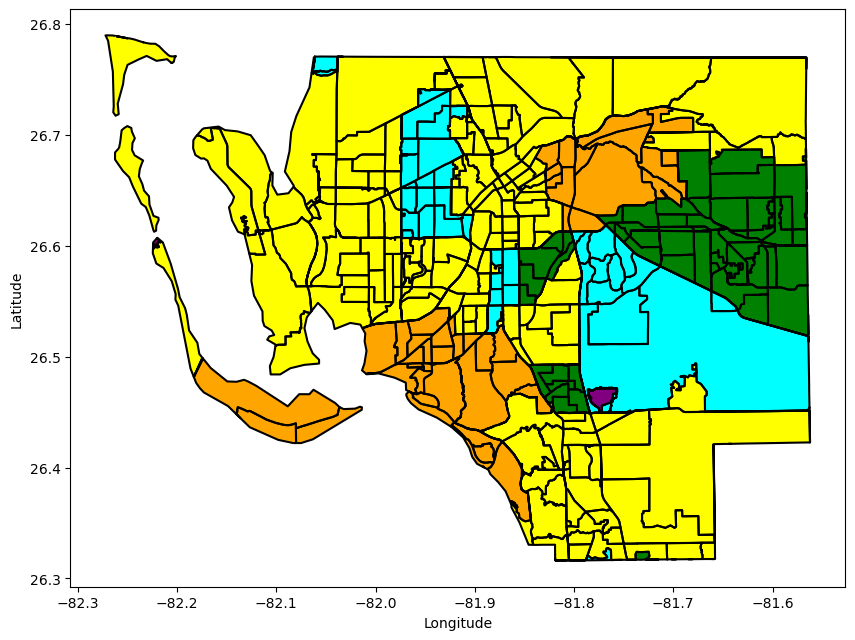

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

joint_tracts_zip.boundary.plot(ax=ax, edgecolor='black')
joint_tracts_zip.plot(ax=ax, color=damage_colors)

plt.show()

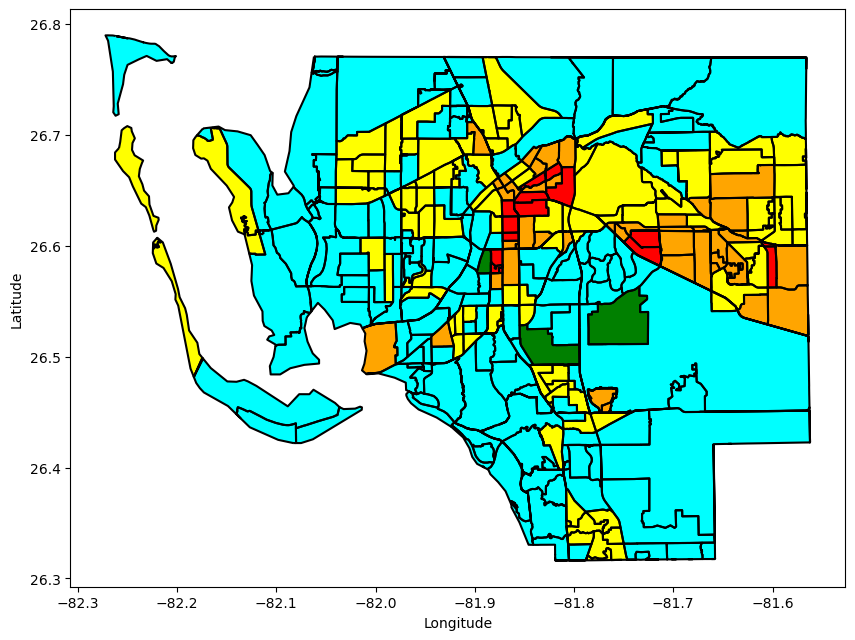

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

joint_tracts_zip.boundary.plot(ax=ax, edgecolor='black')
joint_tracts_zip.plot(ax=ax, color=sv_zone_colors)

plt.show()